In [1]:
import glob
import time
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from scipy.integrate import odeint
plt.rcParams['font.size'] = '14'

# Function to generate the samples
def generate_samples(parameters,samples = 1):
    np.random.seed(2021) # For reproducibility
    A = np.random.rand(samples,parameters)
    B = np.random.rand(samples,parameters)
    C = np.empty((parameters,samples,parameters))
    for c in range(parameters):
        C[c] = A.copy()
        C[c,:,c] = B[:,c].copy()
    return [A,B,C]

# Function to read the experimental data
def read_data(figure_name='full_data',save=False,show=False):
    allfilenames=[['control','Control'],['hypio','Hypoxic IO'],['norio','Normoxic IO'],['e','Evofosfamide'],['hypioe','Hypoxic IO + E'],['norioe','Normoxic IO + E']]
    full_data = []
    for i in range(len(allfilenames)):
        scn = allfilenames[i]
        FilenamesList = sorted(glob.glob('../data/data_mean_std_' +  scn[0] + '_tv.dat'))
        for file in FilenamesList:
            u = np.loadtxt(file)
            full_data.append(u)
    if show or save:
        nCols = 3
        nRows = int(len(allfilenames)/nCols)
        lw = 1
        fig, axes = plt.subplots(ncols=nCols,nrows=nRows,figsize=(6.5*nCols, 4.5*nRows))
        axes.shape = (nCols*nRows)
        for s in range(len(allfilenames)):
            ax = axes[s]
            ax.text(0.5,0.9,allfilenames[s][1],horizontalalignment='center',transform=ax.transAxes)
            ax.errorbar(full_data[s][:,0],full_data[s][:,1],full_data[s][:,2],linestyle='None',color='black',marker='o',capsize=5,label=allfilenames[s][1])
            ax.set_xlabel('Time (days)')
            ax.set_ylabel('Tumor volume (cm³)');
            ax.set_xlim((0,30))
            ax.set_ylim((0,8))
        if save:
            plt.savefig(figure_name + '.pdf', bbox_inches = 'tight', pad_inches = 0.02)
        if show:
            plt.show()
        else:
            plt.close(fig) 
    return [full_data,allfilenames]

@jit
def model_4(y, t, theta):
    tumor = theta[0] * y[0] - theta[3] * y[0] * y[1]
    vessel = theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]

@jit
def model_6(y, t, theta):
    D = theta[3]
    if t>=7:
        n_treat = int((t-7)/3)
        n = t-(7+3*np.arange(0,n_treat+1))
        D += np.sum(theta[4]*np.exp(-theta[5]*n))
    tumor = theta[0] * y[0] - D * y[0] * y[1]
    vessel = theta[1] * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]

@jit
def model_8(y, t, theta):
    De = theta[1]
    n = np.array([13,14,15,16,17])
    De += np.sum(theta[6]*np.exp(-theta[7]*(t-n[t>=n])))
    tumor = theta[0] * y[0] - theta[3] * y[0] * y[1]
    vessel = De * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]

@jit
def model_10(y, t, theta):
    D = theta[3]
    De = theta[1]
    if t>=7:
        n_treat = int((t-7)/3)
        n = t-(7+3*np.arange(0,n_treat+1))
        D += np.sum(theta[4]*np.exp(-theta[5]*n))
    n = np.array([13,14,15,16,17])
    De += np.sum(theta[6]*np.exp(-theta[7]*(t-n[t>=n])))
    tumor = theta[0] * y[0] - D * y[0] * y[1]
    vessel = De * ( 1.0 - y[1] ) - theta[2] * y[0] * y[1]
    return [tumor,vessel]

def solve_matrix(A,time_range,ic,scenario,dofs = 2):
    solA = np.empty((A.shape[0],len(time_range),dofs))
    for l in range(A.shape[0]):
        samples = A[l].copy()
        samples[0] *= 0.4
        samples[1] *= 0.5
        samples[2] *= 0.5
        samples[3] *= 0.5
        samples[4] *= 1.75
        samples[5] *= 0.2
        samples[6] *= 1.75
        samples[7] *= 0.2
        if scenario[0] == 'control':
            sol = odeint(model_4, t=time_range, y0=[ic,1-samples[-1]], args=tuple([samples]))
        elif scenario[0] == 'hypio':
            sol = odeint(model_6, t=time_range, y0=[ic,1-samples[-1]], args=tuple([samples]))
        elif scenario[0] == 'e':
            sol = odeint(model_8, t=time_range, y0=[ic,1-samples[-1]], args=tuple([samples]))
        elif scenario[0] == 'hypioe':
            sol = odeint(model_10, t=time_range, y0=[ic,1-samples[-1]], args=tuple([samples]))
        solA[l] = sol.copy()
    return solA

def run_sensitivity_analysis(A,B,C,time_range,ic,scenario):
    print("Computing the sensitivity analysis: " + scenario[1])
    solA = solve_matrix(A,time_range,ic,scenario)
    solB = 0
    #solve_matrix(B,time_range,ic,scenario)
    solC = []
    for c in range(C.shape[0]):
        if scenario[0] == 'control' and c > 3 and c < 8:
            continue
        elif scenario[0] == 'hypio' and c > 5 and c < 8:
            continue
        elif scenario[0] == 'e' and c > 3 and c < 6:
            continue
        solD = solve_matrix(C[c],time_range,ic,scenario)
        solC.append(solD)
    return [solA,solB,solC]

def analyze_results(solA,sC):
    temporal_sa = np.empty((len(sC),len(solA[0][:,0])-1))
    for t in range(1,len(solA[0][:,0])):
        yaa = sum(solA[:,t][:,0]**2)
        ya2 = sum(solA[:,t][:,0])
        vy = (yaa / len(solA)) - (ya2 / len(solA))**2
        for p in range(len(sC)):
            st = (sum((solA[:,t][:,0]-sC[p][:,t][:,0])**2) / (2 * len(solA)))/vy
            temporal_sa[p][t-1] = st
    return temporal_sa

def convergence_results(solA,sC,burnin = 100):
    if burnin>=len(solA):
        burnin = int(len(solA)/2)
    temporal_sa = np.empty((len(sC),len(solA)-burnin))
    for c in range(burnin,len(solA)):
        t = -1
        yaa = sum(solA[:c,t][:,0]**2)
        ya2 = sum(solA[:c,t][:,0])
        vy = (yaa / c) - (ya2 / c)**2
        for p in range(len(sC)):
            st = (sum((solA[:c,t][:,0]-sC[p][:c,t][:,0])**2) / (2 * c))/vy
            temporal_sa[p][c-burnin] = st
    return temporal_sa

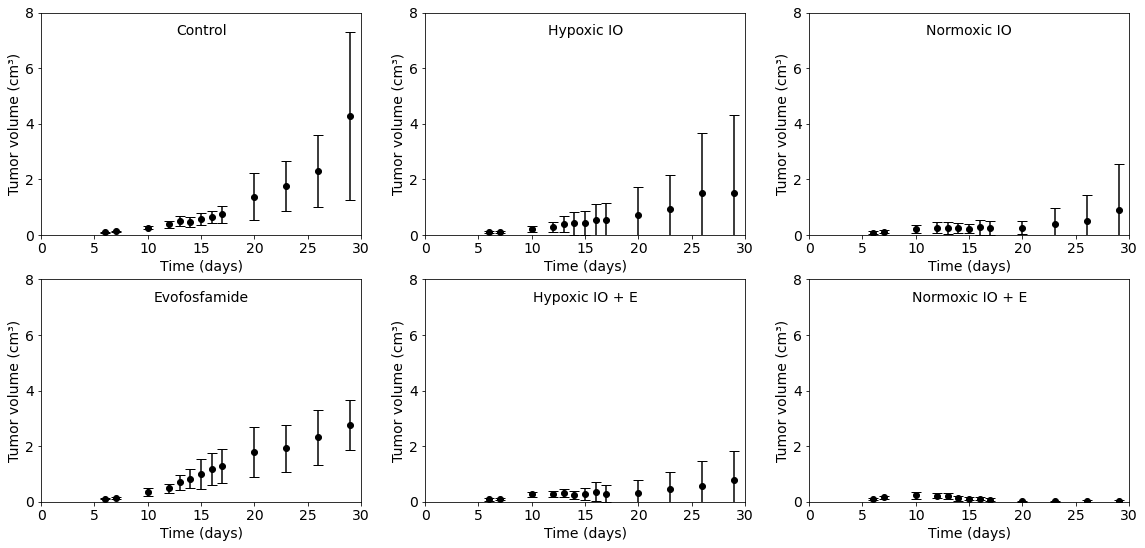

In [2]:
data = read_data(show=True,save=False)

In [3]:
A, B, C = generate_samples(parameters = 9,samples = 100000)

In [4]:
# Finding the initial condition
total = 0
for s in range(len(data[1])):
    total += data[0][s][:,1][0]
ic = total/len(data[1])
t_step = 0.1
time_range = np.arange(data[0][0][:,0][0], data[0][0][:,0][-1] + 0.5 * t_step, t_step)
all_sa = []
scenarios_to_run = [data[1][0], data[1][1], data[1][3], data[1][4]]
for scenario in scenarios_to_run:
    start = time.time()
    solA,solB,solC = run_sensitivity_analysis(A,B,C,time_range,ic,scenario)
    print("Time elapsed to solve:",time.time() - start,"seconds")
    start = time.time()
    temporal_sa = analyze_results(solA,solC)
    print("Time elapsed to analyze:",time.time() - start,"seconds")
    all_sa.append(temporal_sa)

Computing the sensitivity analysis: Control
Time elapsed to solve: 242.85875701904297 seconds
Time elapsed to analyze: 45.2540602684021 seconds
Computing the sensitivity analysis: Hypoxic IO
Time elapsed to solve: 1570.2187705039978 seconds
Time elapsed to analyze: 50.2676465511322 seconds
Computing the sensitivity analysis: Evofosfamide
Time elapsed to solve: 1445.6460282802582 seconds
Time elapsed to analyze: 45.459105253219604 seconds
Computing the sensitivity analysis: Hypoxic IO + E
Time elapsed to solve: 2336.2444632053375 seconds
Time elapsed to analyze: 51.958391427993774 seconds


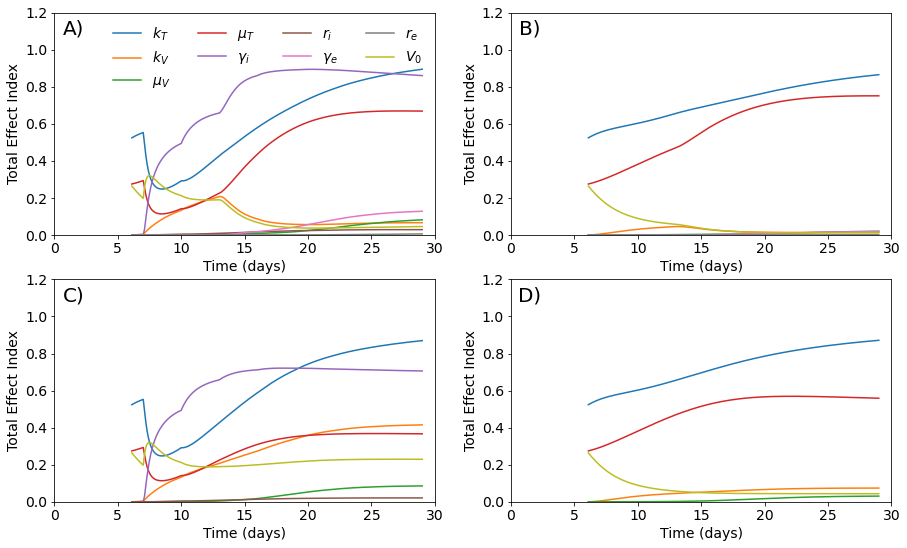

In [5]:
nCols = 2
nRows = 2
lw = 1
colors = np.arange(9)
par_labels = ['$k_T$','$k_V$','$\mu_V$','$\mu_T$','$\gamma_i$','$r_i$','$\gamma_e$','$r_e$','$V_0$']
fig, axes = plt.subplots(ncols=nCols,nrows=nRows,figsize=(7.5*nCols, 4.5*nRows))
axes.shape = (nCols*nRows)
np.savetxt('time_range.txt',np.array(time_range[1:]))
lbl = ['A)','B)','C)','D)']
for s in range(len(all_sa)):
    temporal_sa = all_sa[s]
    np.savetxt('sa_results_' + scenarios_to_run[s][0] + '.txt',np.array(temporal_sa))
    ax = axes[3-s]
    #ax.text(0.5,0.9,scenarios_to_run[s][1].replace('Hypoxic ',''),horizontalalignment='center',transform=ax.transAxes)
    ax.text(0.05,0.9,lbl[3-s],horizontalalignment='center',transform=ax.transAxes,fontsize=20)
    if scenarios_to_run[s][0] == 'control' or scenarios_to_run[s][0] == 'hypio':
        for p in range(len(temporal_sa)-1):
            ax.plot(time_range[1:],temporal_sa[p])
        ax.plot(time_range[1:],temporal_sa[p+1],color='C'+str(colors[-1]))
    elif scenarios_to_run[s][0] == 'e':
        for p in range(len(temporal_sa)-3):
            ax.plot(time_range[1:],temporal_sa[p])
        ax.plot(time_range[1:],temporal_sa[p+1],color='C'+str(colors[-3]))
        ax.plot(time_range[1:],temporal_sa[p+2],color='C'+str(colors[-2]))
        ax.plot(time_range[1:],temporal_sa[p+3],color='C'+str(colors[-1]))
    else:
        for p in range(len(temporal_sa)):
            ax.plot(time_range[1:],temporal_sa[p],label=par_labels[p])
        ax.legend(loc='upper right', fancybox=False, shadow=False, frameon=False,ncol=4)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Total Effect Index');
    ax.set_xlim((0,30))
    ax.set_ylim((0,1.2))
plt.savefig('sensitivity_analysis.pdf', bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

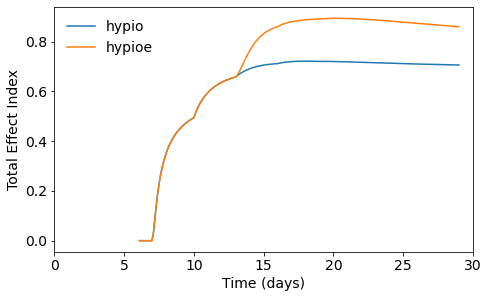

In [6]:
nCols = 2
nRows = 2
lw = 1
colors = np.arange(9)
par_labels = ['$k_T$','$k_V$','$\mu_V$','$\mu_T$','$\gamma_i$','$r_i$','$\gamma_e$','$r_e$','$h_f$']
fig, ax = plt.subplots(figsize=(7.5, 4.5))
for s in range(len(all_sa)):
    temporal_sa = all_sa[s]
    p = 4
    if scenarios_to_run[s][0] == 'control' or scenarios_to_run[s][0] == 'e':
        continue
    ax.plot(time_range[1:],temporal_sa[p],label=scenarios_to_run[s][0])
ax.legend(loc='upper left', fancybox=False, shadow=False, frameon=False)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Total Effect Index');
ax.set_xlim((0,30))
#ax.set_ylim((0,1))
plt.savefig('gamma.pdf', bbox_inches = 'tight', pad_inches = 0.02)
plt.show()